# 5.10 캐글 주택 가격 예측: 고급 회귀 기법

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

house_df_org=pd.read_csv('/content/drive/MyDrive/ML_data_examples/house_prices.csv')
house_df=house_df_org.copy()

print(house_df.shape)
house_df.head(3)

## 컬럼은 81개인데 행데이터가 1460개밖에 안됨-> 차원의저주 및 다중공선성문제 발생 가능
## 그래서 차원축소 알고리즘으로 컬럼 수를 좀 줄여보거나/ 중요피처만 선택해서 돌리는 방법도 있음.

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
for col in house_df.columns:
  print(house_df[col].value_counts())

1460    1
479     1
481     1
482     1
483     1
       ..
976     1
977     1
978     1
979     1
1       1
Name: Id, Length: 1460, dtype: int64
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64
7200     25
9600     24
6000     17
10800    14
9000     14
         ..
7094      1
6130      1
9337      1
5232      1
8190      1
Name: LotArea, Length: 1073, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311


In [ ]:
# Null값의 개수와 그 열의 dtype을 함께 출력
import pandas as pd

print(house_df.shape,'\n')
print(house_df.dtypes.value_counts(),'\n')

isnull=house_df.isnull().sum()
isnull_series=isnull[isnull>0].sort_values(ascending=False)

dtypes=house_df[isnull_series.index].dtypes

null_series_dtypes=pd.concat([isnull_series,dtypes],axis=1,keys=['NULL','Dtypes'])

print(null_series_dtypes)

(1460, 81) 

object     43
int64      35
float64     3
dtype: int64 

              NULL   Dtypes
PoolQC        1453   object
MiscFeature   1406   object
Alley         1369   object
Fence         1179   object
FireplaceQu    690   object
LotFrontage    259  float64
GarageYrBlt     81  float64
GarageType      81   object
GarageFinish    81   object
GarageQual      81   object
GarageCond      81   object
BsmtFinType2    38   object
BsmtExposure    38   object
BsmtFinType1    37   object
BsmtCond        37   object
BsmtQual        37   object
MasVnrArea       8  float64
MasVnrType       8   object
Electrical       1   object


In [ ]:
# Garage없는 집 81개인것 확인
print(house_df[house_df['GarageCars']==0]['GarageCars'].count())
house_df[house_df['GarageArea']==0]['GarageArea'].count()

81


81

## 로그변환 및 피처엔지니어링

**로그변환으로 타겟값, 왜곡도 심한 피처를 정규분포의 형태에 가깝게 만들어주기!**

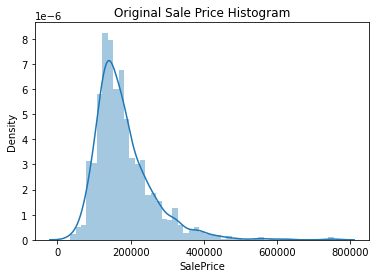

In [ ]:
# 1. 타겟값 SalePrice 분포도 확인-> 로그변환
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

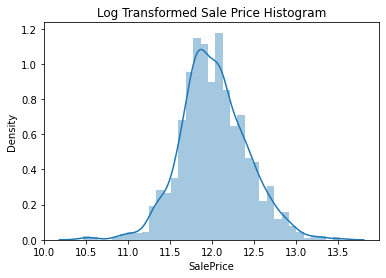

In [ ]:
# 로그변환
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice=np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [ ]:
# 타겟값인 Price를 로그변환하여 정규분포 형태로 변환
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

# 결측값이 많은 피처와 쓸모없는 year피처 드랍
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
               'YrSold','MoSold'],axis=1,inplace=True)
house_df.shape    # 81-8=73개

(1460, 73)

In [ ]:
## MasVnrArea는 MasVnrType의 분포도 확인
pd.set_option('display.max_rows', 20)

cond1=house_df['MasVnrArea']==0
cond2=house_df['MasVnrType']=='None'

a=house_df[cond1&cond2][['MasVnrArea','MasVnrType']]
print(a.count())

print(house_df[house_df['MasVnrType']=='None']['MasVnrType'].count())
print(house_df[house_df['MasVnrArea']==0]['MasVnrArea'].count())

MasVnrArea    859
MasVnrType    859
dtype: int64
864
861


In [ ]:
# 오류 데이터 수정
## MaxVnrArea가 0인 것 중 MaxVnrType이 None이 아니면 None으로 바꾸고, 
## MaxVnrType가 None인 것 중 MaxVnrArea가 0이 아니면 0으로 변환

ind1=house_df[house_df['MasVnrType']=='None'].index
ind2=house_df[house_df['MasVnrArea']==0].index

union=list(set(ind1)|set(ind2))

for ind in union:
  house_df.loc[ind,'MasVnrArea']=0
  house_df.loc[ind,'MasVnrType']='None'

print(house_df[house_df['MasVnrType']=='None']['MasVnrType'].count())
print(house_df[house_df['MasVnrArea']==0]['MasVnrArea'].count())

866
866


In [ ]:
import pandas as pd

print(house_df.shape,'\n')
print(house_df.dtypes.value_counts(),'\n')

isnull=house_df.isnull().sum()
isnull_series=isnull[isnull>0].sort_values(ascending=False)

dtypes=house_df[isnull_series.index].dtypes

null_series_dtypes=pd.concat([isnull_series,dtypes],axis=1,keys=['NULL','Dtypes'])

print(null_series_dtypes)

(1460, 81) 

object     43
int64      35
float64     3
dtype: int64 

              NULL   Dtypes
PoolQC        1453   object
MiscFeature   1406   object
Alley         1369   object
Fence         1179   object
FireplaceQu    690   object
LotFrontage    259  float64
GarageYrBlt     81  float64
GarageType      81   object
GarageFinish    81   object
GarageQual      81   object
GarageCond      81   object
BsmtFinType2    38   object
BsmtExposure    38   object
BsmtFinType1    37   object
BsmtCond        37   object
BsmtQual        37   object
MasVnrArea       8  float64
MasVnrType       8   object
Electrical       1   object


In [ ]:
# null값인 숫자형 피처 변환
## LotFrontage는 평균값으로 결측치 채우기
house_df['LotFrontage'].fillna(house_df['LotFrontage'].mean(),inplace=True)
house_df['MasVnrArea'].fillna(house_df['MasVnrArea'].mean(),inplace=True)

In [46]:
# 'Garage의 유무를 나타내는 이진열을 추가' 및 '원핫인코딩으로 결측치 해결되는지 확인' (예시로 연습)
a=pd.DataFrame({'a':[1,2,3,4],'b':[2,3,4,5],'c':['ab',np.nan,'sd','sa']})
a['a']=3
print(a)

series=pd.Series(a['c'].notnull(),name='c_0')

ind=series[series==False].index
series[ind]=0
ind_0=series[series==True].index
series[ind_0]=1

a1=pd.get_dummies(a,columns=['c'])
a2=pd.concat([a1,series],axis=1)
a2

   a  b    c
0  3  2   ab
1  3  3  NaN
2  3  4   sd
3  3  5   sa


,a,b,c_ab,c_sa,c_sd,c_0
0,3,2,1,0,0,1
1,3,3,0,0,0,0
2,3,4,0,0,1,1
3,3,5,0,1,0,1


In [ ]:
# Garage의 유무 관련 피처 생성 + 연도 관련 피처 수정! 
## 연도는 대부분 숫자가 크기에 중요하지 않은 값임에도 불구하고 클수록 중요한 피처로 인식해 예측에 방해가 될 수 있음.
## 따라서, 오래된 정도로 변경(연도는 따로 나온게 없으므로 분석시기인 2021년을 기준)
garage=pd.Series(house_df['GarageYrBlt'].notnull(),name='Garage')

ind_g0=garage[garage==False].index
garage[ind_g0]=0

ind_g1=garage[garage==True].index
garage[ind_g1]=1

print(garage.value_counts())

GYr_old=2021-house_df.GarageYrBlt
RYr_old=2021-house_df.YearRemodAdd
Yr_old=2021-house_df.YearBuilt

house_df['garage']=garage
house_df['GYr_old']=GYr_old
house_df['RYr_old']=RYr_old
house_df['Yr_old']=Yr_old

print(house_df.shape)

house_df.drop(['GarageYrBlt','YearRemodAdd','YearBuilt'],axis=1,inplace=True)
house_df.shape

1    1379
0      81
Name: Garage, dtype: int64
(1460, 77)


(1460, 74)

In [ ]:
house_df['GYr_old'].fillna(house_df['GYr_old'].mean(),inplace=True)

In [ ]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [ ]:
# 숫자 피처의 왜곡도 수정 - 로그변환
from scipy.stats import skew
features_index=house_df.dtypes[house_df.dtypes!='object'].index
skew_features=house_df[features_index].apply(lambda x:skew(x))

## skew 정도가 1 이상인 컬럼들만 추출
skew_features_top=skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.689407
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [ ]:
# 왜곡도가 1이상인 피처들을 로그변환
house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

**원-핫 인코딩을 통해 object형 피처를 숫자형 카테고리 피처로 만들고, null값도 해결
(문자열 피처는 원핫인코딩 변환시 Null값이 None컬럼으로 대체됨)**

In [ ]:
# 2. object형 피처에 대해 원-핫 인코딩
print('get_dummies() 수행 전 데이터 shape:',house_df.shape)
house_df_ohe=pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape:',house_df_ohe.shape,'\n')

# null값 모두 평균으로 대체되거나 인코딩되거나 삭제되었음을 알 수 있음.
house_df_ohe.isnull().sum().sum()

get_dummies() 수행 전 데이터 shape: (1460, 74)
get_dummies() 수행 후 데이터 shape: (1460, 271) 



0

## 선형회귀 모델의 학습/예측/평가

In [ ]:
# RMSE 평가 함수 생성
def get_rmse(model):
    pred=model.predict(X_test)
    mse=mean_squared_error(y_test,pred)
    rmse=np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse,3)))
    return rmse

def get_rmses(models):
    rmses=[]
    for model in models:
        rmse=get_rmse(model)
        rmses.append(rmse)
    return rmses

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)

X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.2,
                                               random_state=156)

lr=LinearRegression()
lr.fit(X_train,y_train)
ridge=Ridge()
ridge.fit(X_train,y_train)
lasso=Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

models=[lr,ridge,lasso]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.125
Lasso 로그 변환된 RMSE: 0.119


[0.12844157629364836, 0.12483707790393629, 0.11939553910488802]

In [ ]:
# 회귀계수값 시각화를 위해 상위 10개, 하위 10개 회귀계수값과 컬럼명을 가지는 함수 생성
def get_top_bottom_coef(model):
    coef=pd.Series(model.coef_,index=X_features.columns)
    coef_high=coef.sort_values(ascending=False).head(10)
    coef_low=coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

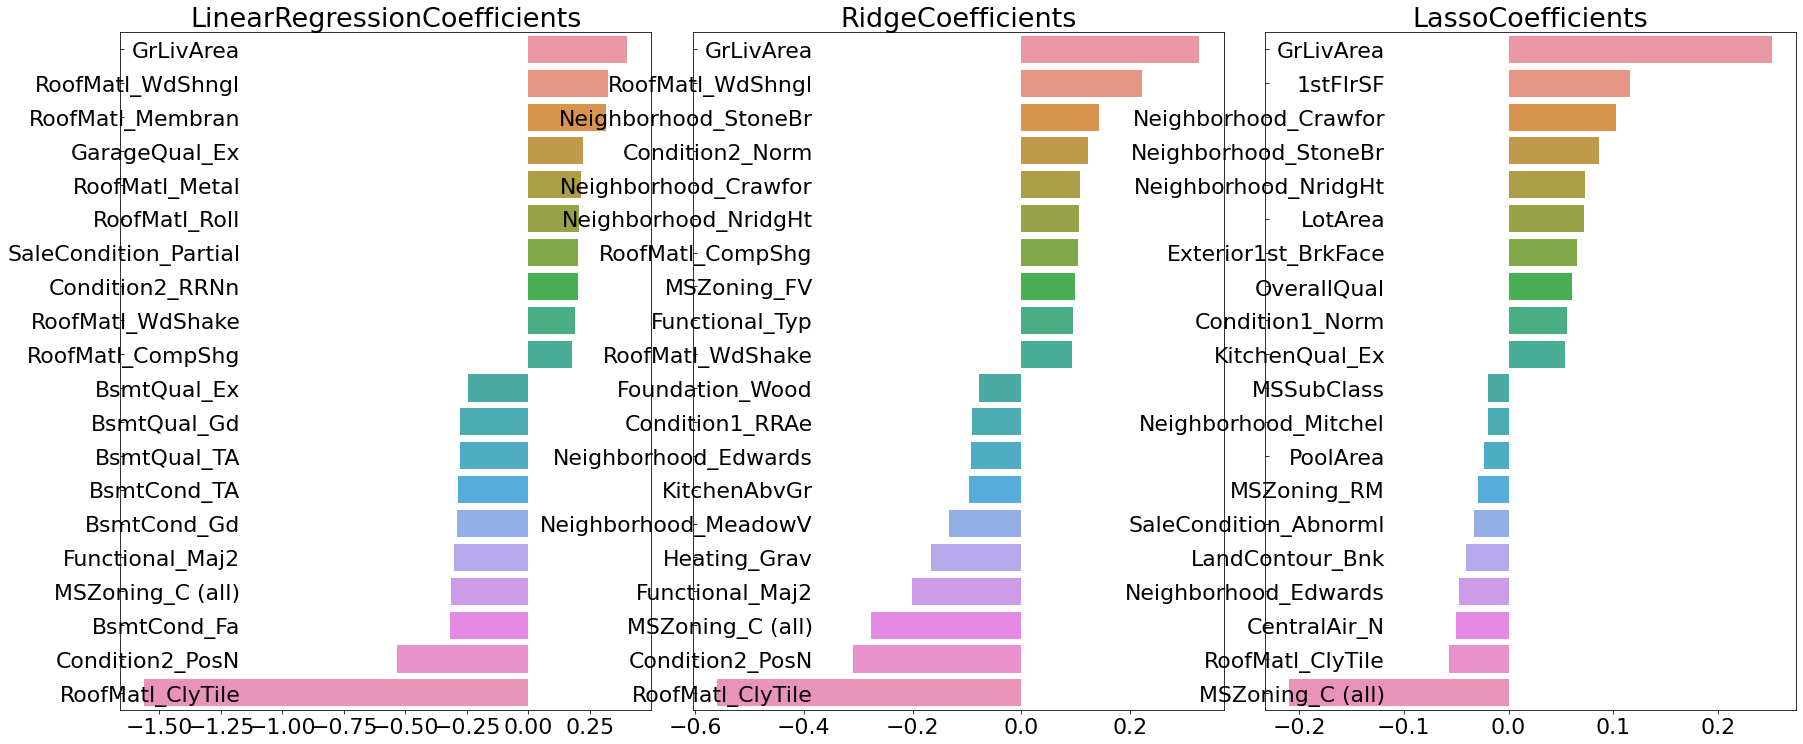

In [ ]:
# 회귀계수값 시각화
import seaborn as sns

def visualize_coefficient(models):
    fig,axs=plt.subplots(figsize=(24,10),nrows=1,ncols=3)
    fig.tight_layout()
  
    for i,model in enumerate(models):
        coef_high,coef_low=get_top_bottom_coef(model)
        coef_concat=pd.concat([coef_high,coef_low],axis=0)

        axs[i].set_title(model.__class__.__name__+'Coefficients',size=27)
        axs[i].tick_params(axis='y',direction='in',pad=-120)
        for label in (axs[i].get_xticklabels()+axs[i].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values,y=coef_concat.index,ax=axs[i])

models=[lr,ridge,lasso]
visualize_coefficient(models)

In [ ]:
## 4장 복붙 베이지안 최적화할 때, 참고!
bayes_params={'learning_rate':(0.01,0.09),'num_leaves':(20,40),'colsample_bytree':(0.5,1),'subsample':(0.5,1),\
              'max_depth':(10,20),'reg_alpha':(0,0.5),'reg_lambda':(0,0.5),\
              'min_split_gain':(0.001,0.1),'min_child_weight':(1,10)}

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

def lgb_roc_eval(learning_rate,num_leaves,colsample_bytree,subsample,max_depth,reg_alpha,reg_lambda,min_split_gain,min_child_weight):
    params={'n_estimators':200,'learning_rate':learning_rate,'num_leaves':int(round(num_leaves)),'colsample_bytree':colsample_bytree,
            'subsample':subsample,'max_depth':int(round(max_depth)),'reg_alpha':reg_alpha,'reg_lambda':reg_lambda,
            'min_split_gain':min_split_gain,'min_child_weight':min_child_weight,'verbosity':-1}

    lgb_model=LGBMClassifier(**params)
    lgb_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=30,eval_metric='auc',verbose=100)
    valid_proba=lgb_model.predict_proba(X_test)[:,1]
    roc_preds=roc_auc_score(y_test,valid_proba)
    return roc_preds

!pip install Bayesian-Optimization

from bayes_opt import BayesianOptimization
BO_lgb=BayesianOptimization(lgb_roc_eval,bayes_params,random_state=156)

BO_lgb.maximize(init_points=5,n_iter=10)

BO_lgb.max

max_params=BO_lgb.max['params']

max_params['num_leaves']=int(round(max_params['num_leaves']))
max_params['max_depth']=int(round(max_params['max_depth']))

lgbm_clf=LGBMClassifier(n_estimators=1000,**max_params)

evals=[(X_test,y_test)]

lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=evals)

lgbm_roc_score=roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1])

print(f'ROC AUC: {lgbm_roc_score:.4f}')

In [ ]:
!pip install Bayesian-Optimization

  Created wheel for Bayesian-Optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=c81ac24f2a7f88a5ede6dcad45ab0132b71dca2550386cc10e400b6f98e16dc3
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built Bayesian-Optimization


In [ ]:
# 릿지 베이지안 최적화 돌려보기
rb_params={'alpha_r':(8,15)}

def ridge_eval(alpha_r):
    ridge=Ridge(alpha_r)
    ridge.fit(X_train,y_train)
    pred=ridge.predict(X_test)
    mse=mean_squared_error(y_test,pred)
    rmse=np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(ridge.__class__.__name__,np.round(rmse,3)))
    return -1*rmse

from bayes_opt import BayesianOptimization
BO_ridge=BayesianOptimization(ridge_eval,rb_params,random_state=156)
BO_ridge.maximize(init_points=10,n_iter=20)
BO_ridge.max

|   iter    |  target   |  alpha_r  |
-------------------------------------
Ridge 로그 변환된 RMSE: 0.123
|  1        | -0.1226   |  10.2     |
Ridge 로그 변환된 RMSE: 0.123
|  2        | -0.1226   |  11.91    |
Ridge 로그 변환된 RMSE: 0.123
|  3        | -0.1226   |  9.837    |
Ridge 로그 변환된 RMSE: 0.123
|  4        | -0.1226   |  9.312    |
Ridge 로그 변환된 RMSE: 0.123
|  5        | -0.1226   |  11.4     |
Ridge 로그 변환된 RMSE: 0.123
|  6        | -0.1227   |  13.73    |
Ridge 로그 변환된 RMSE: 0.123
|  7        | -0.1227   |  13.76    |
Ridge 로그 변환된 RMSE: 0.123
|  8        | -0.1227   |  13.49    |
Ridge 로그 변환된 RMSE: 0.123
|  9        | -0.1226   |  9.934    |
Ridge 로그 변환된 RMSE: 0.123
|  10       | -0.1226   |  10.6     |
Ridge 로그 변환된 RMSE: 0.123
|  11       | -0.1227   |  14.98    |
Ridge 로그 변환된 RMSE: 0.123
|  12       | -0.1227   |  8.012    |
Ridge 로그 변환된 RMSE: 0.123
|  13       | -0.1227   |  14.92    |
Ridge 로그 변환된 RMSE: 0.123
|  14       | -0.1227   |  8.093    |
Ridge 로그 변환된 RMSE: 0.123
|  15       | -0.

{'params': {'alpha_r': 10.598192658181777}, 'target': -0.12262409381641462}

In [ ]:
# 라쏘 베이지안 최적화 돌려보기
lb_params={'alpha_l':(0.001,10)}

def lasso_eval(alpha_l):
    lasso=Lasso(alpha_l)
    lasso.fit(X_train,y_train)
    pred=lasso.predict(X_test)
    mse=mean_squared_error(y_test,pred)
    rmse=np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(lasso.__class__.__name__,np.round(rmse,3)))
    return -1*rmse

from bayes_opt import BayesianOptimization
BO_lasso=BayesianOptimization(lasso_eval,lb_params,random_state=156)
BO_lasso.maximize(init_points=10,n_iter=20)
BO_lasso.max

|   iter    |  target   |  alpha_l  |
-------------------------------------
Lasso 로그 변환된 RMSE: 0.275
|  1        | -0.2745   |  3.137    |
Lasso 로그 변환된 RMSE: 0.284
|  2        | -0.284    |  5.59     |
Lasso 로그 변환된 RMSE: 0.268
|  3        | -0.2678   |  2.625    |
Lasso 로그 변환된 RMSE: 0.26
|  4        | -0.2601   |  1.875    |
Lasso 로그 변환된 RMSE: 0.283
|  5        | -0.2835   |  4.86     |
Lasso 로그 변환된 RMSE: 0.286
|  6        | -0.2865   |  8.183    |
Lasso 로그 변환된 RMSE: 0.287
|  7        | -0.2865   |  8.226    |
Lasso 로그 변환된 RMSE: 0.286
|  8        | -0.2861   |  7.846    |
Lasso 로그 변환된 RMSE: 0.269
|  9        | -0.2695   |  2.763    |
Lasso 로그 변환된 RMSE: 0.283
|  10       | -0.2827   |  3.712    |
Lasso 로그 변환된 RMSE: 0.119
|  11       | -0.1194   |  0.001    |
Lasso 로그 변환된 RMSE: 0.119
|  12       | -0.1194   |  0.001    |
Lasso 로그 변환된 RMSE: 0.119
|  13       | -0.1194   |  0.001    |
|  14       | -0.1194   |  0.001    |
Lasso 로그 변환된 RMSE: 0.119
|  15       | -0.1194   |  0.001    |
Lasso

{'params': {'alpha_l': 0.001}, 'target': -0.11939553910488802}

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model,params):
    grid_model=GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_features,y_target)
    rmse=np.sqrt(-1*grid_model.best_score_)
    print('{0} 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params={'alpha':[0.05,0.1,1,5,8,10,11,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.,0.5,1,5,10]}

get_best_params(ridge,ridge_params)
get_best_params(lasso,lasso_params)

Ridge 최적 평균 RMSE 값: 0.1274, 최적 alpha:{'alpha': 11}
Lasso 최적 평균 RMSE 값: 0.1249, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.123
Lasso 로그 변환된 RMSE: 0.119


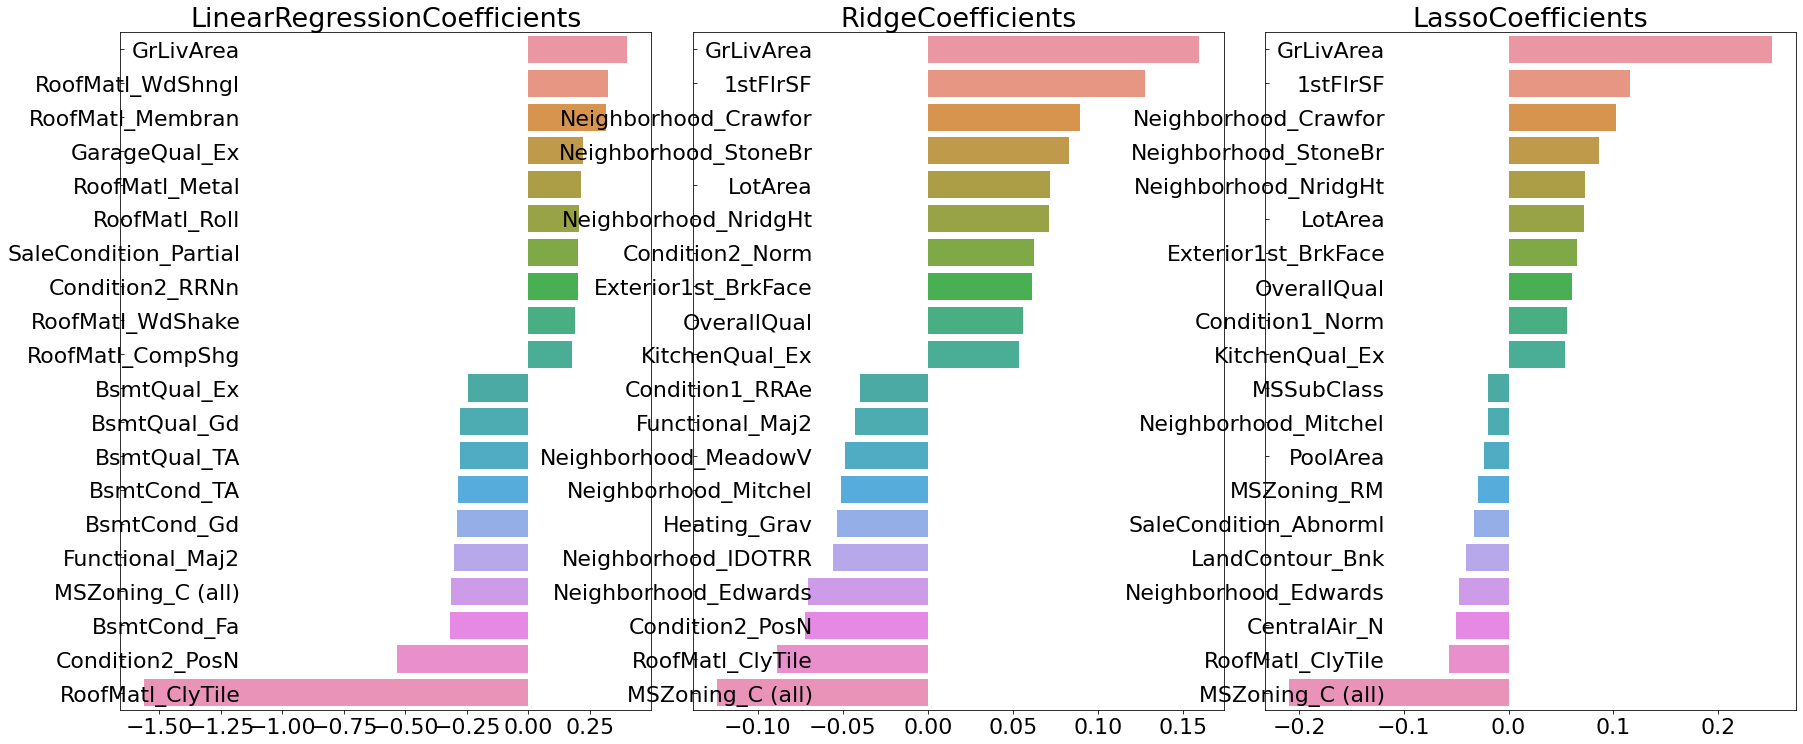

In [ ]:
# 최적화한 alpha값을 가지고 회귀계수 시각화
lr=LinearRegression()
lr.fit(X_train,y_train)
ridge=Ridge(alpha=11)
ridge.fit(X_train,y_train)
lasso=Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

models=[lr,ridge,lasso]
get_rmses(models)
visualize_coefficient(models)

## 이상치 데이터 검출 및 제거

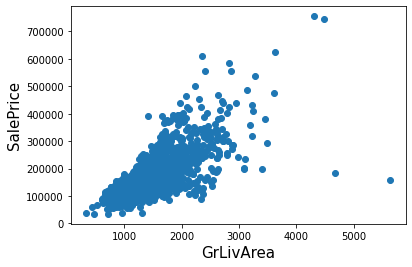

In [ ]:
## house_df_org으로 하는 이유는 (로그변환한 상태의 산점도보다) 이상치가 눈에 확 뜨임!!
plt.scatter(x=house_df_org['GrLivArea'],y=house_df_org['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('GrLivArea',fontsize=15)
plt.show()

In [ ]:
# 이상치 데이터 삭제 후 학습/예측/평가
## GrLivArea,SalePrice 모두 로그 변환된 상태이므로 이를 반영한 조건 생성**
cond1=house_df_ohe['GrLivArea']>np.log1p(4000)
cond2=house_df_ohe['SalePrice']<np.log1p(300000)
outlier_index=house_df_ohe[cond1&cond2].index

print('아웃라이어 레코드 index:',outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:',house_df_ohe.shape)

## 아웃라이어 삭제하기
house_df_ohe.drop(outlier_index,axis=0,inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:',house_df_ohe.shape)

아웃라이어 레코드 index: [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


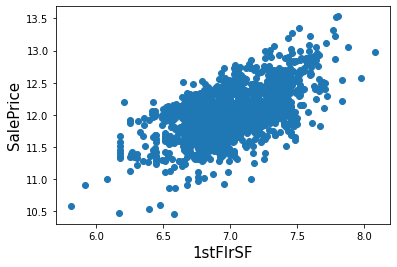

In [ ]:
# GrLivArea의 이상치를 제거하니 나머지 피처의 이상치도 자동으로 제거됨!
plt.scatter(x=house_df_ohe['1stFlrSF'],y=house_df_ohe['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('1stFlrSF',fontsize=15)
plt.show()

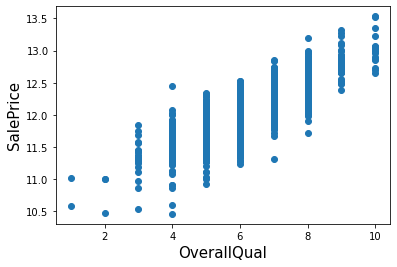

In [ ]:
plt.scatter(x=house_df_ohe['OverallQual'],y=house_df_ohe['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('OverallQual',fontsize=15)
plt.show()

In [ ]:
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)

X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.2,
                                               random_state=156)

In [ ]:
# 릿지 베이지안 최적화 돌려보기
rb_params={'alpha_r':(5,15)}

def ridge_eval(alpha_r):
    ridge=Ridge(alpha_r)
    ridge.fit(X_train,y_train)
    pred=ridge.predict(X_test)
    mse=mean_squared_error(y_test,pred)
    rmse=np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(ridge.__class__.__name__,np.round(rmse,3)))
    return -1*rmse

from bayes_opt import BayesianOptimization
BO_ridge=BayesianOptimization(ridge_eval,rb_params,random_state=156)
BO_ridge.maximize(init_points=15,n_iter=20)
BO_ridge.max

|   iter    |  target   |  alpha_r  |
-------------------------------------
Ridge 로그 변환된 RMSE: 0.103
|  1        | -0.1028   |  8.136    |
Ridge 로그 변환된 RMSE: 0.102
|  2        | -0.1024   |  10.59    |
Ridge 로그 변환된 RMSE: 0.103
|  3        | -0.1029   |  7.624    |
Ridge 로그 변환된 RMSE: 0.103
|  4        | -0.1031   |  6.875    |
Ridge 로그 변환된 RMSE: 0.103
|  5        | -0.1025   |  9.859    |
Ridge 로그 변환된 RMSE: 0.102
|  6        | -0.1023   |  13.18    |
Ridge 로그 변환된 RMSE: 0.102
|  7        | -0.1023   |  13.23    |
Ridge 로그 변환된 RMSE: 0.102
|  8        | -0.1023   |  12.85    |
Ridge 로그 변환된 RMSE: 0.103
|  9        | -0.1029   |  7.762    |
Ridge 로그 변환된 RMSE: 0.103
|  10       | -0.1027   |  8.712    |
Ridge 로그 변환된 RMSE: 0.103
|  11       | -0.1032   |  6.707    |
Ridge 로그 변환된 RMSE: 0.103
|  12       | -0.1027   |  8.33     |
Ridge 로그 변환된 RMSE: 0.102
|  13       | -0.1025   |  10.02    |
Ridge 로그 변환된 RMSE: 0.103
|  14       | -0.1026   |  9.012    |
Ridge 로그 변환된 RMSE: 0.104
|  15       | -0.

{'params': {'alpha_r': 13.225822349625357}, 'target': -0.10232298232899752}

In [ ]:
# 라쏘 베이지안 최적화 돌려보기
lb_params={'alpha_l':(0.0003,0.001)}

def lasso_eval(alpha_l):
    lasso=Lasso(alpha_l)
    lasso.fit(X_train,y_train)
    pred=lasso.predict(X_test)
    mse=mean_squared_error(y_test,pred)
    rmse=np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(lasso.__class__.__name__,np.round(rmse,3)))
    return -1*rmse

from bayes_opt import BayesianOptimization
BO_lasso=BayesianOptimization(lasso_eval,lb_params,random_state=156)
BO_lasso.maximize(init_points=15,n_iter=50)
BO_lasso.max

|   iter    |  target   |  alpha_l  |
-------------------------------------
Lasso 로그 변환된 RMSE: 0.101
|  1        | -0.1007   |  0.000519 |
Lasso 로그 변환된 RMSE: 0.1
|  2        | -0.1      |  0.000691 |
Lasso 로그 변환된 RMSE: 0.101
|  3        | -0.1008   |  0.000483 |
Lasso 로그 변환된 RMSE: 0.101
|  4        | -0.1008   |  0.000431 |
Lasso 로그 변환된 RMSE: 0.1
|  5        | -0.1003   |  0.000640 |
Lasso 로그 변환된 RMSE: 0.099
|  6        | -0.09946  |  0.000872 |
Lasso 로그 변환된 RMSE: 0.099
|  7        | -0.09946  |  0.000875 |
Lasso 로그 변환된 RMSE: 0.099
|  8        | -0.09946  |  0.000849 |
Lasso 로그 변환된 RMSE: 0.101
|  9        | -0.1008   |  0.000493 |
Lasso 로그 변환된 RMSE: 0.101
|  10       | -0.1005   |  0.000559 |
Lasso 로그 변환된 RMSE: 0.101
|  11       | -0.1008   |  0.000419 |
Lasso 로그 변환된 RMSE: 0.101
|  12       | -0.1006   |  0.000533 |
Lasso 로그 변환된 RMSE: 0.1
|  13       | -0.1002   |  0.000651 |
Lasso 로그 변환된 RMSE: 0.1
|  14       | -0.1005   |  0.000580 |
Lasso 로그 변환된 RMSE: 0.102
|  15       | -0.1019   |

{'params': {'alpha_l': 0.0008728081304572866}, 'target': -0.09945564931878609}

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.102
Lasso 로그 변환된 RMSE: 0.099


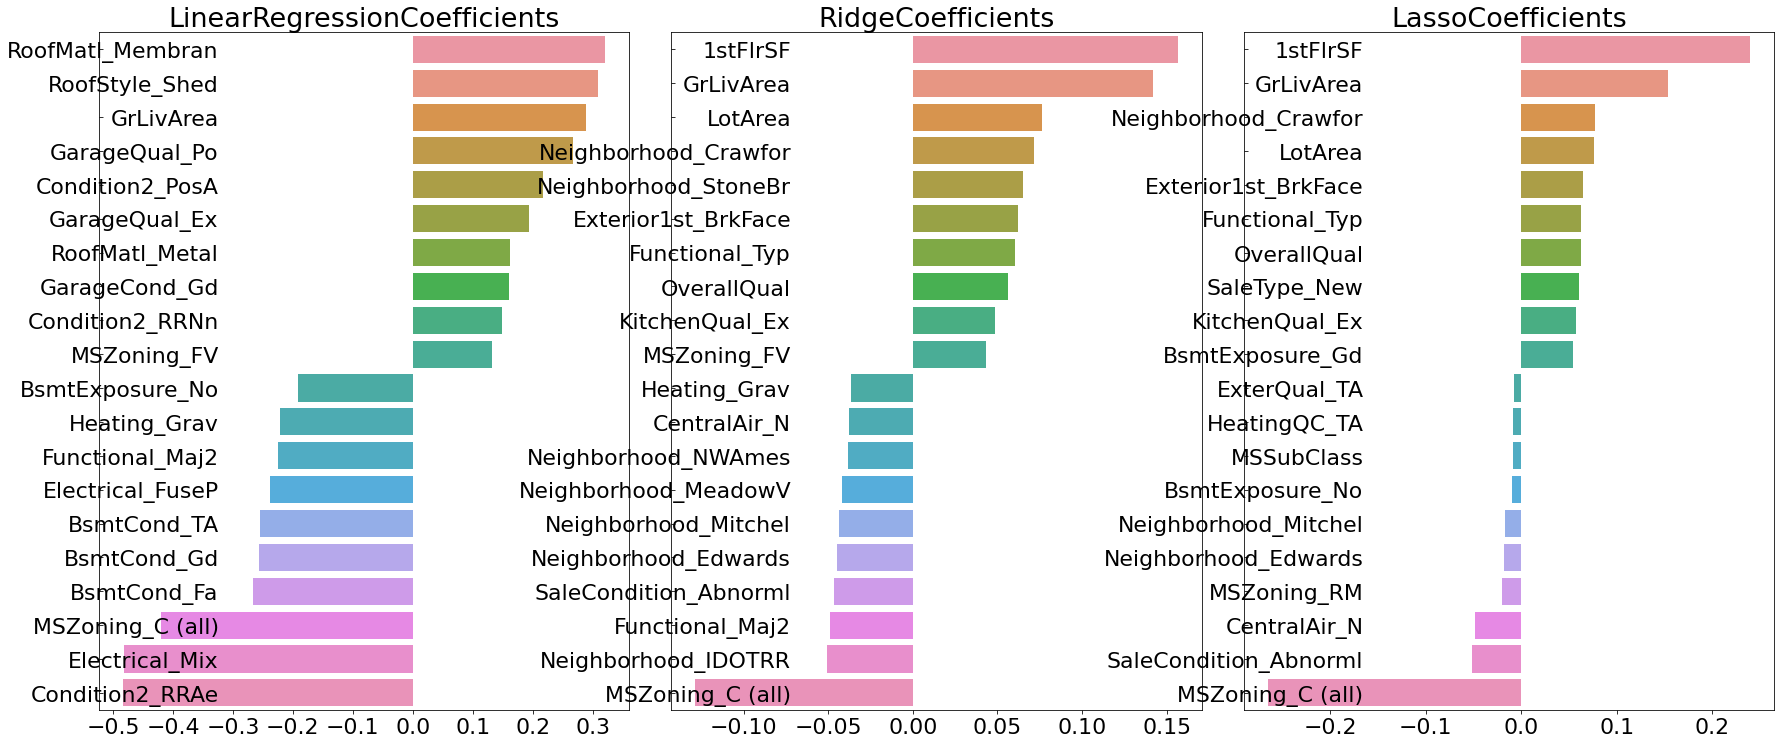

In [ ]:
# 앞에서 최적화된 alpha값으로 학습/예측/평가 수행
lr=LinearRegression()
lr.fit(X_train,y_train)
ridge=Ridge(alpha=13)
ridge.fit(X_train,y_train)
lasso=Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

models=[lr,ridge,lasso]
get_rmses(models)
visualize_coefficient(models)

## 회귀트리 학습/예측/평가

In [ ]:
# XGBoost와 LightGBM로 학습/예측/평가
from xgboost import XGBRegressor

xgb_reg=XGBRegressor(n_estimators=1000,learning_rate=0.05,colsample=0.5,subsample=0.7)
xgb_reg.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',
            early_stopping_rounds=100)
pred=xgb_reg.predict(X_test)
mse=mean_squared_error(y_test,pred)
rmse=np.sqrt(mse)
print('로그변환된 RMSE:',np.round(rmse,3))

[09:37:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.9501
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:10.4032
[2]	validation_0-rmse:9.88414
[3]	validation_0-rmse:9.39173
[4]	validation_0-rmse:8.92411
[5]	validation_0-rmse:8.47925
[6]	validation_0-rmse:8.05664
[7]	validation_0-rmse:7.65445
[8]	validation_0-rmse:7.27325
[9]	validation_0-rmse:6.91134
[10]	validation_0-rmse:6.56685
[11]	validation_0-rmse:6.23933
[12]	validation_0-rmse:5.92882
[13]	validation_0-rmse:5.63403
[14]	validation_0-rmse:5.35346
[15]	validation_0-rmse:5.08693
[16]	validation_0-rmse:4.8349
[17]	validation_0-rmse:4.59344
[18]	validation_0-rmse:4.3654
[19]	validation_0-rmse:4.14903
[20]	validation_0-rmse:3.94339
[21]	validation_0-rmse:3.74776
[22]	validation_0-rmse:3.56149
[23]	validation_0-rmse:3.38535
[24]	validation_0-rmse:3.21685
[25]	validation_0-rmse:3.05797
[26]	validati

In [ ]:
from lightgbm import LGBMRegressor

lgbm_reg=LGBMRegressor(n_estimators=1000,learing_rate=0.05,num_leaves=4,
                       colsample_bytree=0.4,reg_lambda=13,n_jobs=-1)
lgbm_reg.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',
             early_stopping_rounds=100)
pred=lgbm_reg.predict(X_test)
mse=mean_squared_error(y_test,pred)
rmse=np.sqrt(mse)
print('로그변환된 RMSE:',np.round(rmse,3))

[1]	valid_0's l2: 0.143883	valid_0's rmse: 0.37932
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 0.128298	valid_0's rmse: 0.358187
[3]	valid_0's l2: 0.116425	valid_0's rmse: 0.341212
[4]	valid_0's l2: 0.105646	valid_0's rmse: 0.325032
[5]	valid_0's l2: 0.0962522	valid_0's rmse: 0.310245
[6]	valid_0's l2: 0.088827	valid_0's rmse: 0.298039
[7]	valid_0's l2: 0.0803152	valid_0's rmse: 0.283399
[8]	valid_0's l2: 0.073293	valid_0's rmse: 0.270727
[9]	valid_0's l2: 0.067715	valid_0's rmse: 0.260221
[10]	valid_0's l2: 0.0630944	valid_0's rmse: 0.251186
[11]	valid_0's l2: 0.0583745	valid_0's rmse: 0.241608
[12]	valid_0's l2: 0.0545945	valid_0's rmse: 0.233655
[13]	valid_0's l2: 0.0515737	valid_0's rmse: 0.227098
[14]	valid_0's l2: 0.0478973	valid_0's rmse: 0.218855
[15]	valid_0's l2: 0.0443694	valid_0's rmse: 0.21064
[16]	valid_0's l2: 0.0417536	valid_0's rmse: 0.204337
[17]	valid_0's l2: 0.0397123	valid_0's rmse: 0.199279
[18]	valid_0's l2: 0.037327	valid_0's

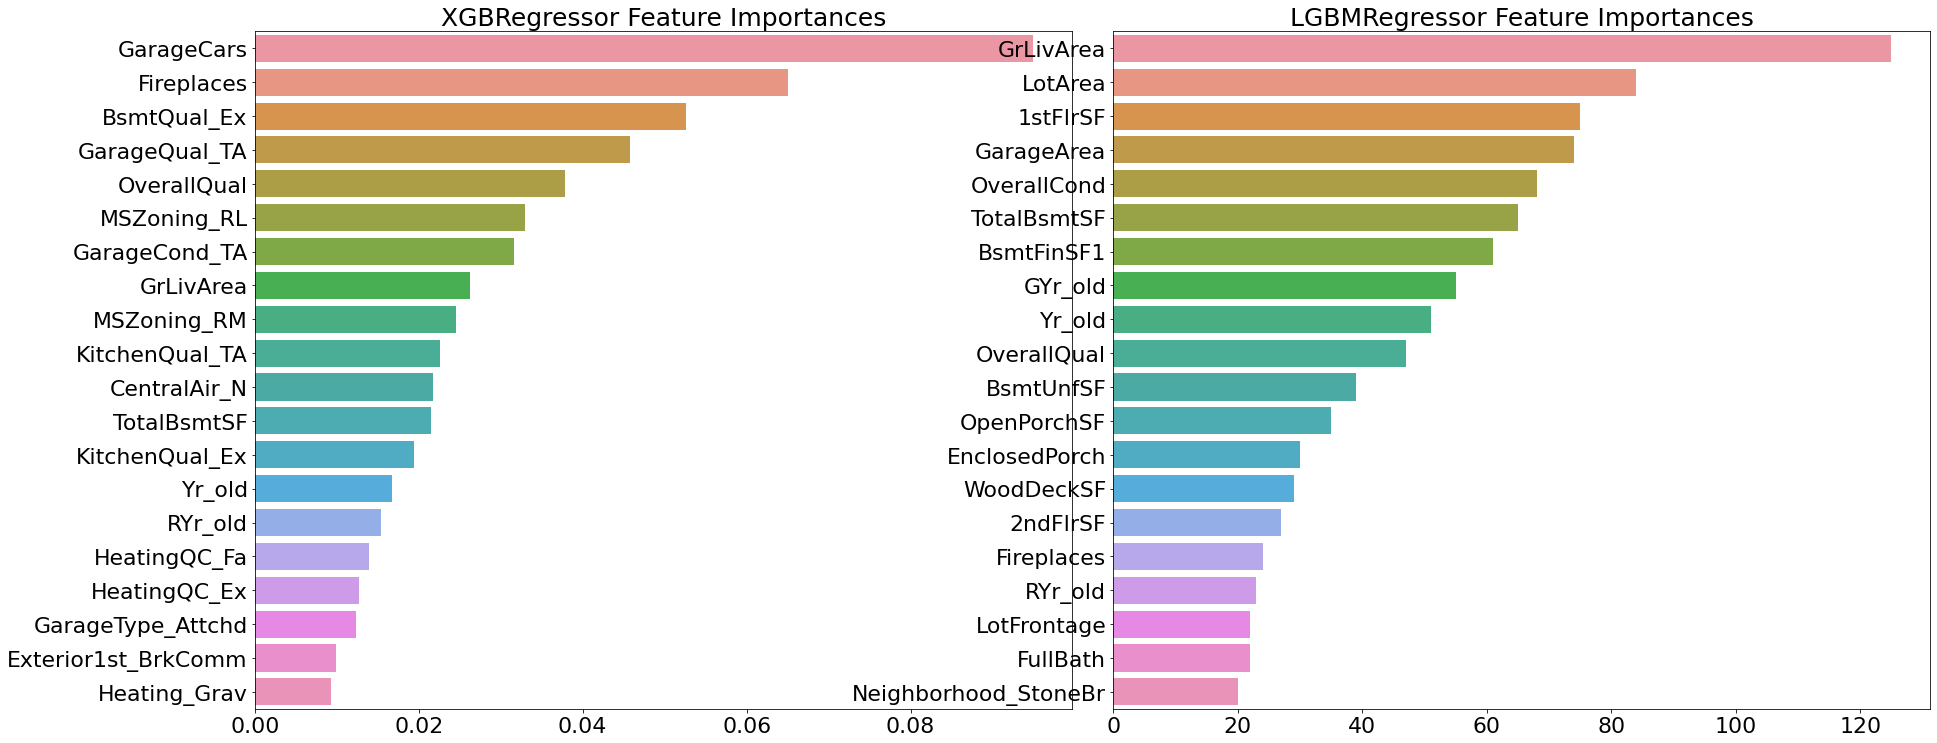

In [ ]:
# 모델의 중요도 사위 20개의 피처명과 중요도값 시각화
def get_top_features(model):
  ftr_importances_values=model.feature_importances_
  ftr_importances=pd.Series(ftr_importances_values,index=X_features.columns)
  ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
  return ftr_top20

def visualize_ftr_importances(models):
  fig,axs=plt.subplots(figsize=(24,10),nrows=1,ncols=2)
  fig.tight_layout()

  for i,model in enumerate(models):
    ftr_top20=get_top_features(model)
    axs[i].set_title(model.__class__.__name__+' Feature Importances',size=25)
    for label in (axs[i].get_xticklabels()+axs[i].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=ftr_top20.values,y=ftr_top20.index,ax=axs[i])

models=[xgb_reg,lgbm_reg]
visualize_ftr_importances(models)

In [ ]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value=preds[key]
    mse=mean_squared_error(y_test,pred_value)
    rmse=np.sqrt(mse)
    print(f'{key} 모델의 RMSE: {rmse}')

# stacking 모델에 쓰기 위해 s붙여주기!
ridge_s=Ridge(alpha=13)
ridge_s.fit(X_train,y_train)
lasso_s=Lasso(alpha=0.001)
lasso_s.fit(X_train,y_train)

ridge_pred=ridge_s.predict(X_test)
lasso_pred=lasso_s.predict(X_test)

pred=0.5*ridge_pred+0.5*lasso_pred
preds={'최종혼합':pred,'Ridge':ridge_pred,'Lasso':lasso_pred}

get_rmse_pred(preds)

최종혼합 모델의 RMSE: 0.09966396306871822
Ridge 모델의 RMSE: 0.10232657055136196
Lasso 모델의 RMSE: 0.09946172771120045


## 스태킹 모델을 통한 회귀 예측

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
  kf=KFold(n_splits=n_folds,shuffle=False,random_state=0)
  
  # 넘파이 배열 초기화
  ## train_fold_pred는 개별 분류기 cv폴드 세트(학습+검증셋) 중 검증 데이터의 예측 결과값의 array
  ## test_pred는 학습 폴드에서 훈련한 모델로 실제 테스트 데이터를 예측한 결과값의 array
  train_fold_pred=np.zeros((X_train_n.shape[0],1),dtype='int32')
  test_pred=np.zeros((X_test_n.shape[0],n_folds),dtype='int32')
  print(model.__class__.__name__,'model 시작')

  # valid index는 검증폴드에 해당하는 인덱스를 의미함! 최종 메타모델의 학습 데이터의 일부
  for folder_counter,(train_index,valid_index) in enumerate(kf.split(X_train_n)):
    print('\t 폴드세트:',folder_counter,'시작')
    X_tr=X_train_n[train_index]
    y_tr=y_train_n[train_index]
    X_te=X_train_n[valid_index]

    model.fit(X_tr,y_tr)

    ## train_fold_pred[valid_index,:]은 2차원! [valid_index,0]로 인덱싱하면 1차원임!
    ## 원래 코드에서 불필요하게 2차원으로 바꿔준 것 같아 1차원에서 해결함
    train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)

    test_pred[:,folder_counter]=model.predict(X_test_n)
    
  test_pred_mean=np.mean(test_pred, axis=1)

  return train_fold_pred,test_pred_mean.reshape(-1,1)

In [ ]:
# 기반 모델은 릿지,라쏘,XGBoost,LightGBM
# 최종 메타 모델은 라쏘로 생성하여 학습/예측/평가
X_train_n=X_train.values
X_test_n=X_test.values
y_train_n=y_train.values

ridge_train,ridge_test=get_stacking_base_datasets(ridge_s,X_train_n,
                                                  y_train_n,X_test_n,5)
lasso_train,lasso_test=get_stacking_base_datasets(lasso_s,X_train_n,
                                                  y_train_n,X_test_n,5)
# xgb_train,xgb_test=get_stacking_base_datasets(xgb_reg,X_train_n,y_train_n,
#                                               X_test_n,5)
# lgbm_train,lgbm_test=get_stacking_base_datasets(lgbm_reg,X_train_n,y_train_n,
#                                                 X_test_n,5)

Ridge model 시작
	 폴드세트: 0 시작
	 폴드세트: 1 시작
	 폴드세트: 2 시작
	 폴드세트: 3 시작
	 폴드세트: 4 시작
Lasso model 시작
	 폴드세트: 0 시작
	 폴드세트: 1 시작
	 폴드세트: 2 시작
	 폴드세트: 3 시작
	 폴드세트: 4 시작


In [ ]:
lasso_train
lgbm_test.shape
xgb_test.shape

(292, 1)

In [ ]:
# 개별모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합!
Stack_final_X_train=np.concatenate((ridge_train,lasso_train),
                                   axis=1)
Stack_final_X_test=np.concatenate((ridge_test,lasso_test),axis=1)

meta_model_lasso=Lasso(alpha=0.0005)

meta_model_lasso.fit(Stack_final_X_train,y_train)
final=meta_model_lasso.predict(Stack_final_X_test)
mse=mean_squared_error(y_test,final)
rmse=np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE:',rmse)

스태킹 회귀 모델의 최종 RMSE: 0.22294174140489903


In [ ]:
# 테스트 데이터에서 돌리기
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

house_df_org=pd.read_csv('/content/drive/MyDrive/ML_data_examples/house_prices_test.csv')
house_df_test=house_df_org.copy()

print(house_df_test.shape)
house_df_test.head(3)

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
